# Comparison of MongoDB 2.6 vs 3.0 for Blazmass Search

### ...including comparison of WiredTiger (new storage engine) vs MMAPv1 (old storage engine)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## testing MongoDB 3.0 and MongoDB 2.13 Java driver (supports v3.0 database)

* Added new 2.13 driver to Blazmass Search (previous version was 2.12)
    * Recompiled Blazmass Search
    * Replaced 'dist' directory on garibaldi with new compiled binary
* Upgraded MongoDB on wl-cmadmin to v3.0.1
    * Still using same database files (same dbpath -- MMAPv1 storage engine)
    
### Are the same numbers of peptide candidates identified in a search using the new software as when using the old Blazmass Search + MongoDB?
***(would indicate that database / query logic is fine)***

In [2]:
import glob
import sys
sys.path.append('/mongoa/ipynb/sandip/021115_sqt_analysis_30ppm/')
import blazmass_tools

# mongo2_oldjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag'
mongo2_oldjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag_duplicate'
mongo3_newjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag_NEWMONGODB'

def get_all_peptide_candidate_counts(sqt_file_path):
    scan_dict = {}
    for sqt_file in glob.glob(sqt_file_path+'/*.sqt'):
        parser = blazmass_tools.sqt_chunker(sqt_file)
        for scan in parser:
            scan_id = sqt_file.split('_')[-1].split('.')[0]+'_'+str(scan['low_scan'])+'_'+str(scan['charge'])
            if scan_id in scan_dict:
                print('found scan already... {}'.format(scan_id))
            else:
                scan_dict[scan_id] = scan['#seq_matching']
                
    return scan_dict

mongo2_oldjavalib_scandict = get_all_peptide_candidate_counts(mongo2_oldjavalib_path)
mongo3_newjavalib_scandict = get_all_peptide_candidate_counts(mongo3_newjavalib_path)

len(mongo2_oldjavalib_scandict), len(mongo3_newjavalib_scandict)

(235728, 235728)

In [3]:
count = 0
for key, val in mongo2_oldjavalib_scandict.items():
    count += 1
    print(key, val)
    if count > 20:
        break

08_19478_2 12210
05_17587_3 15502
06_21740_2 11210
10_8943_2 9544
11_1276_3 17054
10_5589_2 11804
10_10319_3 18996
05_23588_2 12846
02_4847_2 4124
06_8410_2 10692
03_7271_2 7318
01_8469_2 1450
12_5569_2 11716
03_24332_3 12146
09_1813_2 3030
06_11780_3 17114
06_4536_2 9744
05_23117_3 17154
05_8340_2 9086
09_667_3 12906
06_21253_4 16234


In [4]:
same_count, notsame_count = 0, 0

for scan_id in mongo2_oldjavalib_scandict:
    if scan_id in mongo3_newjavalib_scandict:
        if mongo2_oldjavalib_scandict[scan_id] == mongo3_newjavalib_scandict[scan_id]:
            same_count += 1
        else:
            notsame_count += 1

same_count, notsame_count

(235728, 0)

## Database queries seem to be working identically

----
## Storage sizes for database files on disk

    wl-cmadmin sandip> du -sc /mongoa/mongodb/*_HsapiensDB_110214/
    999448	/mongoa/mongodb/MassDB_HsapiensDB_110214/
    213012	/mongoa/mongodb/ProtDB_HsapiensDB_110214/
    4144160	/mongoa/mongodb/SeqDB_HsapiensDB_110214/
    5356620	total
    wl-cmadmin sandip> du -sc /mongoa/mongodb_wt/
    1261636	/mongoa/mongodb_wt/
    1261636	total


In [5]:
# formatting

import matplotlib.font_manager as fm
# fpath = '/usr/share/fonts/helvetica/Helvetica.ttf'
fpath = '/mongoa/ipynb/sandip/HelveticaNeue.ttf'
prop36 = fm.FontProperties(fname=fpath, size=36)
prop32 = fm.FontProperties(fname=fpath, size=32)
prop30 = fm.FontProperties(fname=fpath, size=30)
prop24 = fm.FontProperties(fname=fpath, size=24)
prop20 = fm.FontProperties(fname=fpath, size=20)
prop18 = fm.FontProperties(fname=fpath, size=18)
prop16 = fm.FontProperties(fname=fpath, size=16)
prop14 = fm.FontProperties(fname=fpath, size=14)

color = '#468966'
opacity = 1
file_extension = '.pdf' # .pdf, .jpg, .png

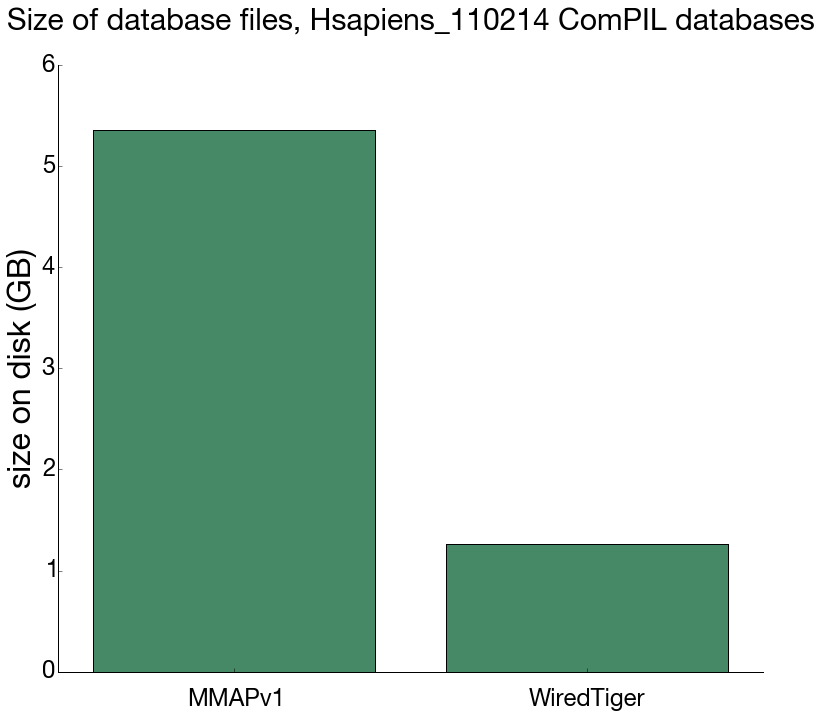

In [6]:
labels = ('MMAPv1', 'WiredTiger')
values = (5356620, 1261636)
values = [val/(10**6) for val in values] ## convert to GB

index = np.arange(1,len(labels)+1) # just [1,2]
heights = values
fig, ax = plt.subplots()
fig.set_size_inches(12,10)

plt.bar(index-0.4, heights, color=color,alpha=opacity)


fmt = plt.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(fmt)
ax.set_ylabel('size on disk (GB)', fontproperties=prop32)

yoff = ax.get_yaxis().get_offset_text() ## exponent at top of y-axis
yoff.set_font_properties(prop14)

for label in ax.get_yticklabels():
    label.set_fontproperties(prop24)
    
ax.set_title('Size of database files, Hsapiens_110214 ComPIL databases', fontproperties=prop30, y=1.05)

remove_border()

ax.set_xticks(index)

ax.set_xticklabels(labels,fontproperties=prop24, y=-0.02)

plt.tight_layout()
plt.show()

In [7]:
import sys
sys.path.append('/mongoa/ipynb/sandip/021115_sqt_analysis_30ppm/')
import blazmass_tools

# mongo2_oldjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag'
mongo2_oldjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag_duplicate'
mongo3_newjavalib_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag_NEWMONGODB'
mongo3_newjavalib_wt_path = 'humanDB_search_noProtDB_30ppm_50ppmfrag_NEWMONGODB_WT'

In [8]:
import glob

def get_process_times(sqt_path):
    process_times = []
    sqt_files = glob.glob(sqt_path+'/*.sqt')
    for sqt_file in sqt_files:
        parser = blazmass_tools.sqt_chunker(sqt_file)
        for scan in parser:
            process_times.append(scan['process_time'])
    return process_times

mongo2_oldjavalib_times = get_process_times(mongo2_oldjavalib_path)
mongo3_newjavalib_times = get_process_times(mongo3_newjavalib_path)
mongo3_newjavalib_wt_times = get_process_times(mongo3_newjavalib_wt_path)

[len(x) for x in (mongo2_oldjavalib_times, mongo3_newjavalib_times, mongo3_newjavalib_wt_times)]

[235728, 235728, 235728]

In [9]:
mongo2_oldjavalib_times[:5]

[1567, 1606, 1615, 1689, 273]

In [10]:
mongo3_newjavalib_times[:5]

[1500, 1443, 1520, 1606, 440]

In [11]:
# remove crazy outliers (probably indicative of some search error -- messes up histogram bins)

def remove_outliers(list_of_process_times, maxval=1000):
    return [x for x in list_of_process_times if x < maxval]

mongo2_oldjavalib_times = remove_outliers(mongo2_oldjavalib_times)
mongo3_newjavalib_times = remove_outliers(mongo3_newjavalib_times)
mongo3_newjavalib_wt_times = remove_outliers(mongo3_newjavalib_wt_times)

[len(x) for x in (mongo2_oldjavalib_times, mongo3_newjavalib_times, mongo3_newjavalib_wt_times)]

[235647, 234727, 235350]

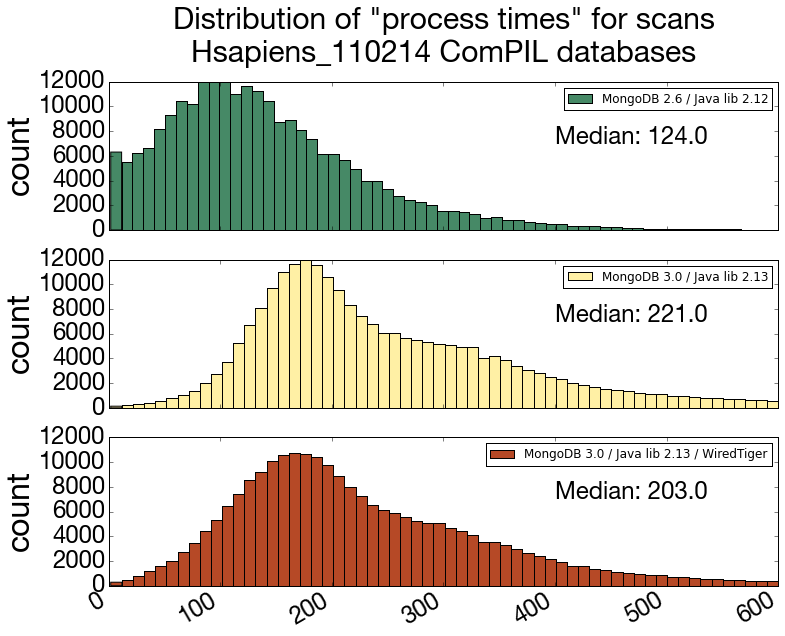

In [12]:
plt.close()

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.set_size_inches(12,10)

ax1.hist(mongo2_oldjavalib_times, bins=100, color=color,alpha=1, label='MongoDB 2.6 / Java lib 2.12')
ax2.hist(mongo3_newjavalib_times, bins=100, color='#FFF0A5',alpha=1, label='MongoDB 3.0 / Java lib 2.13')
ax3.hist(mongo3_newjavalib_wt_times, bins=100, color='#B64926',alpha=1, label='MongoDB 3.0 / Java lib 2.13 / WiredTiger')


ax1.set_ylabel('count', fontproperties=prop32)
ax2.set_ylabel('count', fontproperties=prop32)
ax3.set_ylabel('count', fontproperties=prop32)

ax1.set_xlim(0,600)

for ax_obj in (ax1, ax2, ax3):
    ax_obj.set_ylim(0,12000)

def set_ticklabel_fontprops(ax_obj, fontprop):
    for label_x, label_y in zip(ax_obj.get_xticklabels(), ax_obj.get_yticklabels()):
        label_x.set_fontproperties(prop24)
        label_y.set_fontproperties(prop24)

set_ticklabel_fontprops(ax1, prop24)
set_ticklabel_fontprops(ax2, prop24)
set_ticklabel_fontprops(ax3, prop24)

plt.title('Distribution of "process times" for scans\nHsapiens_110214 ComPIL databases', fontproperties=prop30, y=3.5)
ax1.legend()
ax2.legend()
ax3.legend()

ax1.annotate('Median: {}'.format(np.median(mongo2_oldjavalib_times)), xy=(0,0), xytext=(400,7000), fontproperties=prop24)
ax2.annotate('Median: {}'.format(np.median(mongo3_newjavalib_times)), xy=(0,0), xytext=(400,7000), fontproperties=prop24)
ax3.annotate('Median: {}'.format(np.median(mongo3_newjavalib_wt_times)), xy=(0,0), xytext=(400,7000), fontproperties=prop24)

fig.autofmt_xdate()

## not sure why old MongoDB search was so much faster (lower median process time)

* **lots of variables here**, because that data was collected months ago 
* garibaldi cluster could have had completely different workload then
* might have run on different (faster) nodes
* might have had very different TSRI network traffic at the time... (database is being accessed over the network)

## in any case, WiredTiger doesn't seem to really slow things down much at all using the default "snappy compression"

### let's see if this scales to the big database...